In [1]:
import autoroot
import autorootcwd
import os
from pathlib import Path
import kagglehub

project_cache = Path("./data").resolve()
os.environ["KAGGLEHUB_CACHE"] = str(project_cache)

path = kagglehub.dataset_download("altavish/boston-housing-dataset")
print("Path to dataset files:", path)


Path to dataset files: E:\Om\ds5020_linal_and_prob\project\data\datasets\altavish\boston-housing-dataset\versions\1


In [2]:
import pandas as pd

csv_file_path = r'data\datasets\altavish\boston-housing-dataset\versions\1\HousingData.csv'

df = pd.read_csv(csv_file_path)

# Simple describe
print(df.describe())


             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  486.000000  486.000000  486.000000  486.000000  506.000000  506.000000   
mean     3.611874   11.211934   11.083992    0.069959    0.554695    6.284634   
std      8.720192   23.388876    6.835896    0.255340    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.081900    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.253715    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.560263   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  486.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.518519    3.795043    9.549407  408.237154   18.455534  356.674032   
std     27.999513    2.1057

# Explanations for the Boston Housing dataset features:
*   **CRIM**: per capita crime rate by town
*   **ZN**: proportion of residential land zoned for lots over 25,000 sq.ft.
*   **INDUS**: proportion of non-retail business acres per town
*   **CHAS**: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
*   **NOX**: nitric oxides concentration (parts per 10 million)
*   **RM**: average number of rooms per dwelling
*   **AGE**: proportion of owner-occupied units built prior to 1940
*   **DIS**: weighted distances to five Boston employment centres
*   **RAD**: index of accessibility to radial highways
*   **TAX**: full-value property-tax rate per $10,000
*   **PTRATIO**: pupil-teacher ratio by town
*   **B**: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
*   **LSTAT**: % lower status of the population
*   **MEDV**: Median value of owner-occupied homes in $1000s (target variable)


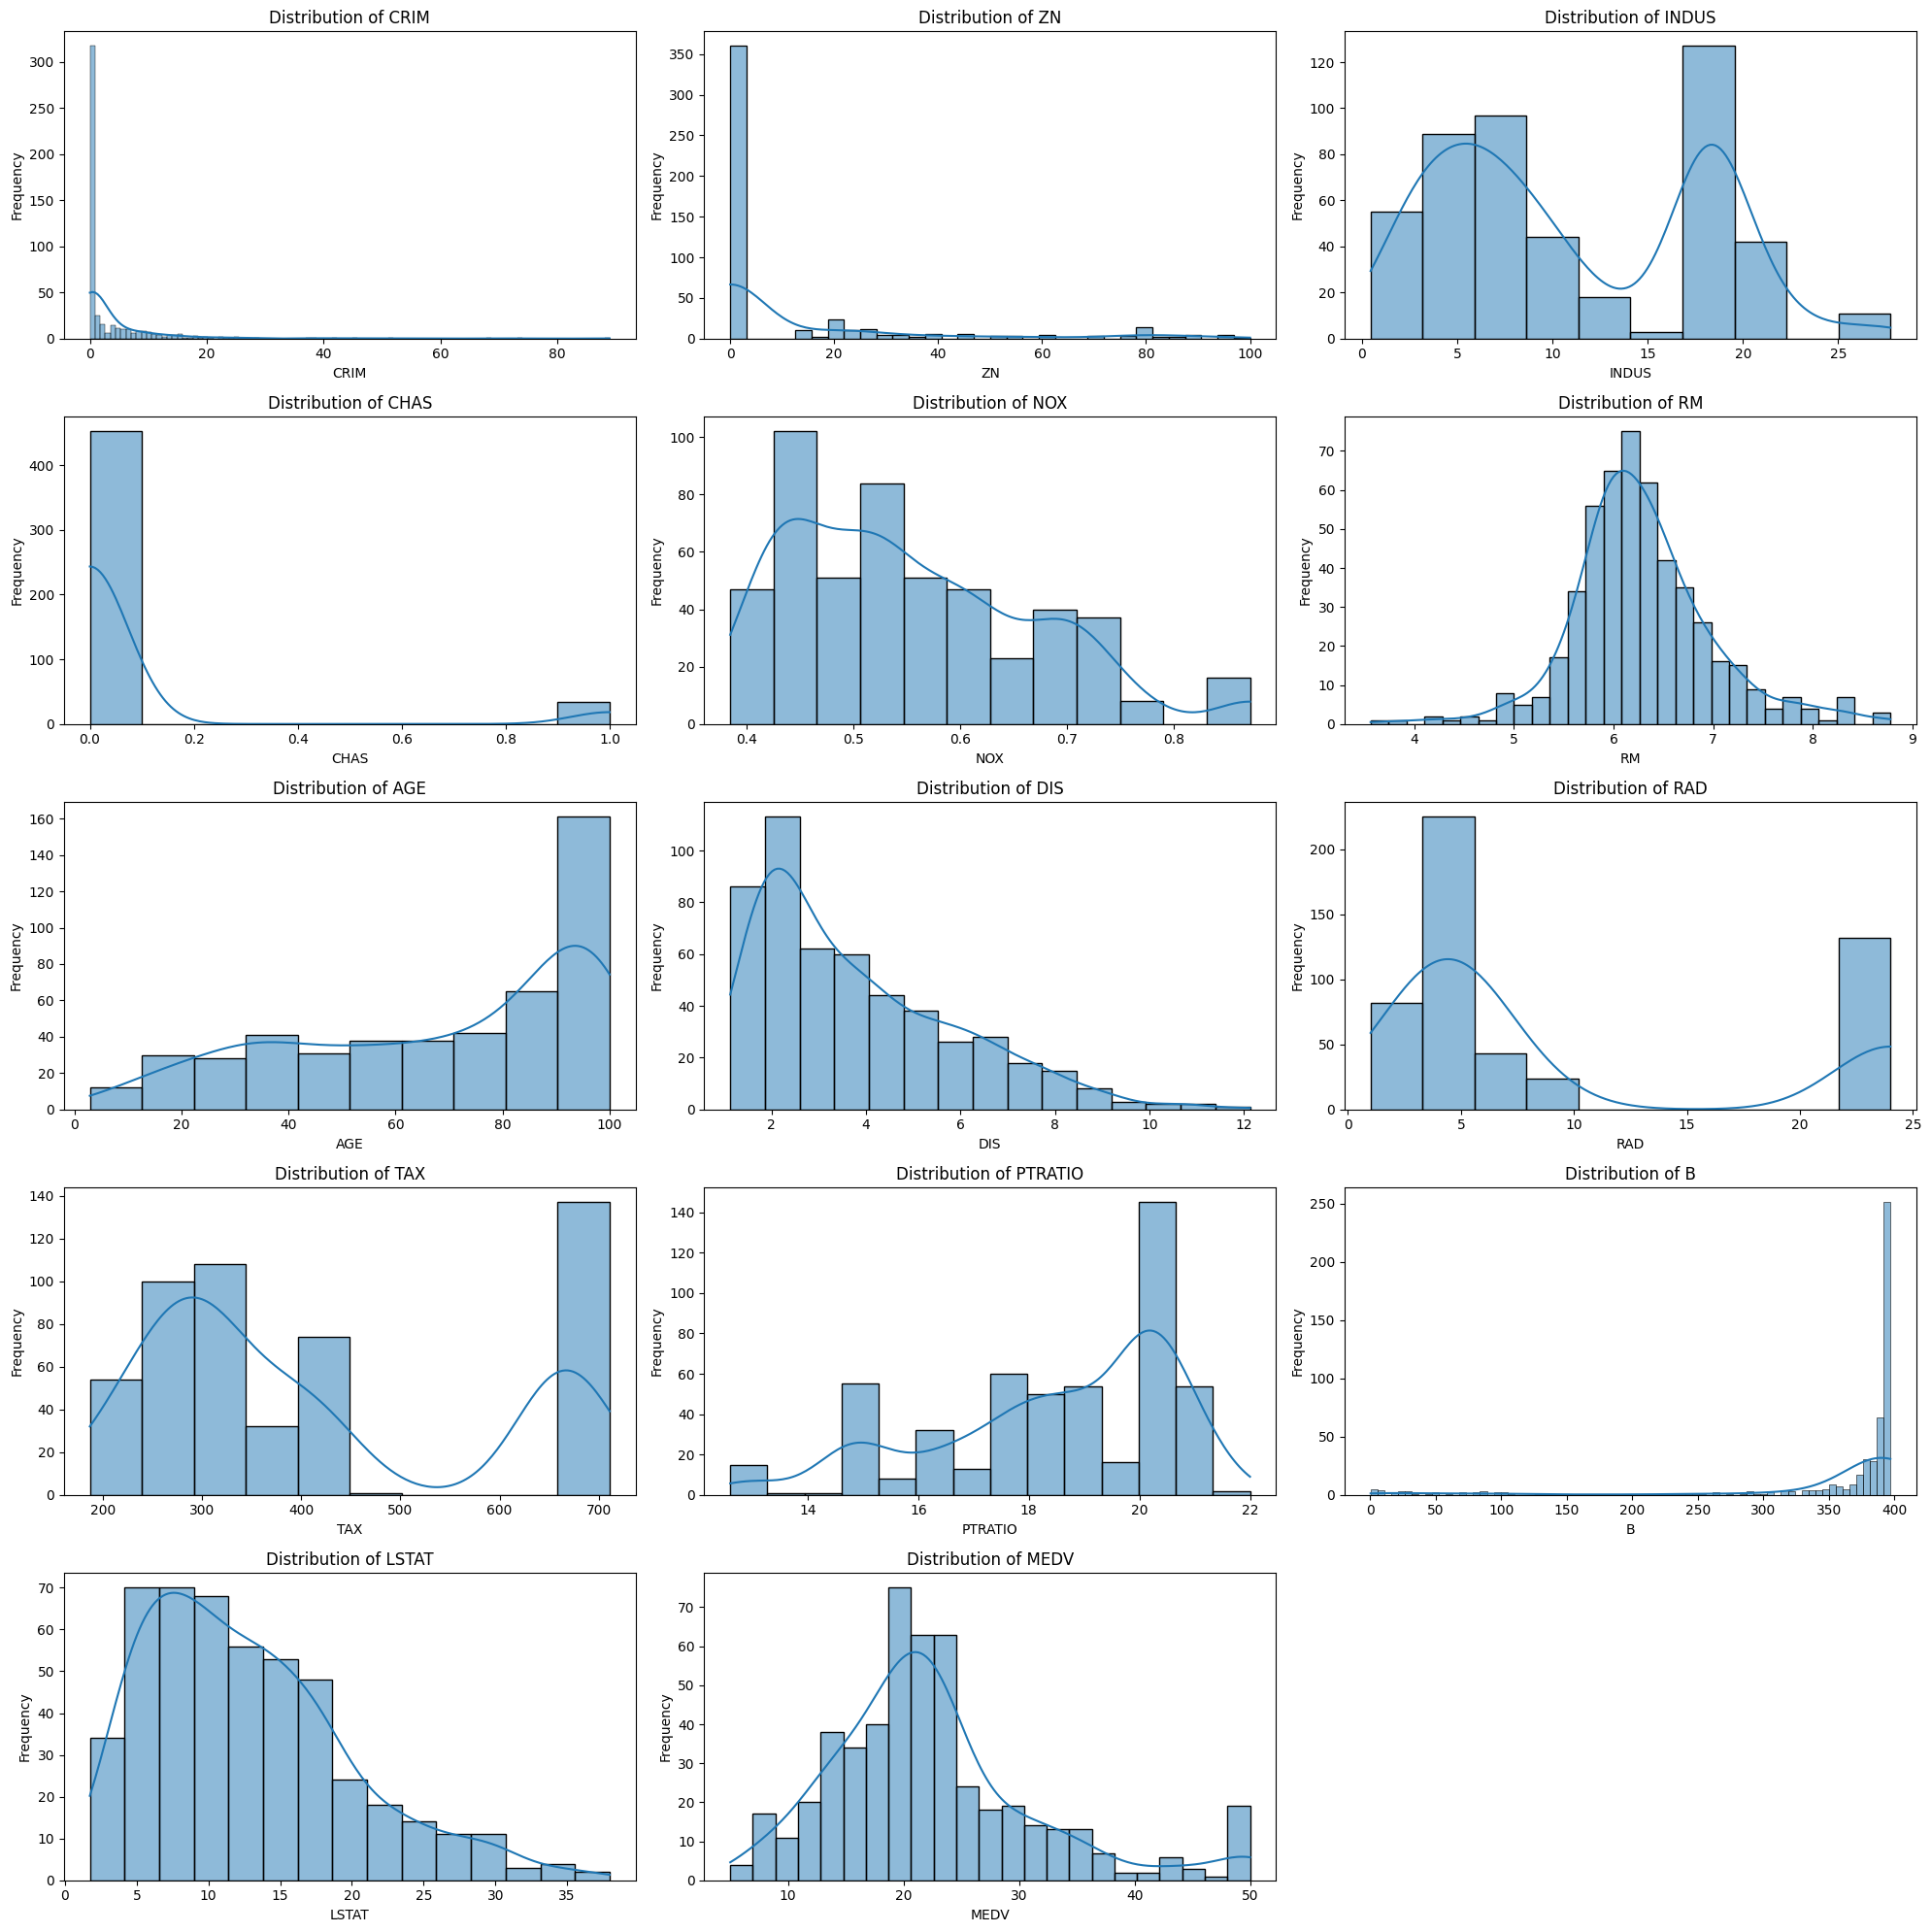

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 20))
axes = axes.flatten()

for idx, column in enumerate(df.columns):
    sns.histplot(df[column], kde=True, ax=axes[idx])
    axes[idx].set_title(f'Distribution of {column}')
    axes[idx].set_xlabel(column)
    axes[idx].set_ylabel('Frequency')

# Remove unused axes if any (in case there are fewer than 15 columns)
for idx in range(len(df.columns), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


In [4]:
X = df[['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT']]
y = df["MEDV"].values.reshape(-1, 1)
left_skewed_features = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'LSTAT', 'DIS', 'NOX']
right_skewed_features = ['B', 'PTRATIO', 'AGE']
normalized_features = ['RM']
bimodal_features = ['RAD','TAX']

In [5]:
# 1. Binary
X["CHAS"].fillna(X["CHAS"].mode()[0], inplace=True)

# 2. Strong right-skewed → median
right_skewed = ["CRIM", "ZN", "INDUS", "NOX", "DIS", "LSTAT", "B"]
X[right_skewed] = X[right_skewed].fillna(X[right_skewed].median())

# 3. Left-skewed → median
X["AGE"].fillna(X["AGE"].median(), inplace=True)

# 4. Normal → mean
X["RM"].fillna(X["RM"].mean(), inplace=True)

# 5. Mild skew → median
X["PTRATIO"].fillna(X["PTRATIO"].median(), inplace=True)

# 6. Bimodal discrete → mode
X["RAD"].fillna(X["RAD"].mode()[0], inplace=True)
X["TAX"].fillna(X["TAX"].mode()[0], inplace=True)

C:\Users\omras\AppData\Local\Temp\ipykernel_28344\1419158014.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X["CHAS"].fillna(X["CHAS"].mode()[0], inplace=True)
C:\Users\omras\AppData\Local\Temp\ipykernel_28344\1419158014.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["CHAS"].fillna(X["CHAS"].mode()[0], inplace=True)
C:\Users\omras\

In [6]:
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans


# Corrected groups
bimodal = ['RAD', 'TAX']

# Add cluster labels to X before building the pipeline
for col in bimodal:
    X[col + "_cluster"] = KMeans(n_clusters=2, random_state=0).fit_predict(X[[col]])

categorical_features = ['CHAS'] + [col + "_cluster" for col in bimodal]
left_skewed = ['CRIM', 'ZN', 'INDUS', 'LSTAT', 'DIS', 'NOX']
right_skewed = ['B', 'PTRATIO', 'AGE']
normal_features = ['RM']

preprocessor = ColumnTransformer(
    transformers=[
        ("left_skewed", Pipeline([
            ("pt", PowerTransformer(method="yeo-johnson")),
            ("scaler", StandardScaler())
        ]), left_skewed),

        ("right_skewed", Pipeline([
            ("pt", PowerTransformer(method="yeo-johnson")),
            ("scaler", StandardScaler())
        ]), right_skewed),

        ("normal", StandardScaler(), normal_features),

        ("bimodal_raw_scaled", RobustScaler(), bimodal),

        ("categorical", "passthrough", categorical_features),
    ]
)


In [7]:
from sklearn.model_selection import train_test_split

# Assume X and y are already defined and preprocessed as needed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train).ravel()   # mean 0, std 1
y_test_scaled = y_scaler.fit_transform(y_test).ravel()   # mean 0, std 1

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

print(X.shape, X_train_proc.shape, X_test_proc.shape)

(506, 15) (404, 15) (102, 15)


In [8]:
import numpy as np

# 1. Compute XᵀX and Xᵀy
XtX = X_train_proc.T @ X_train_proc        # shape: (d, d)
Xty = X_train_proc.T @ y_train_scaled         # shape: (d,)
# Use pinv for numerical stability instead of explicit inverse
w_hat = np.linalg.pinv(XtX) @ Xty          # shape: (d,)
# 3. Predictions ŷ = X w
y_pred_train = X_train_proc @ w_hat               # shape: (n,)
# 4. Residuals r = y - ŷ
residuals_train = y_train_scaled - y_pred_train                # shape: (n,)

In [9]:
# Test
y_pred_test = X_test_proc @ w_hat               # shape: (n,)
# Residuals r = y - ŷ
residuals_test = y_test_scaled - y_pred_test                # shape: (n,)

In [11]:
# Train residuals are distributed as N(mean, sigma^2)
train_mean = np.mean(residuals_train)
train_std = np.std(residuals_train)
print(f"ε_train ~ N({train_mean:.3f}, {train_std:.3f}²)")

# Test residuals are distributed as N(mean, sigma^2)
test_mean = np.mean(residuals_test)
test_std = np.std(residuals_test)
print(f"ε_test ~ N({test_mean:.3f}, {test_std:.3f}²)")


ε_train ~ N(0.013, 0.480²)
ε_test ~ N(0.215, 0.521²)


In [12]:
y_test.shape, y_pred_test.shape

((102, 1), (102,))

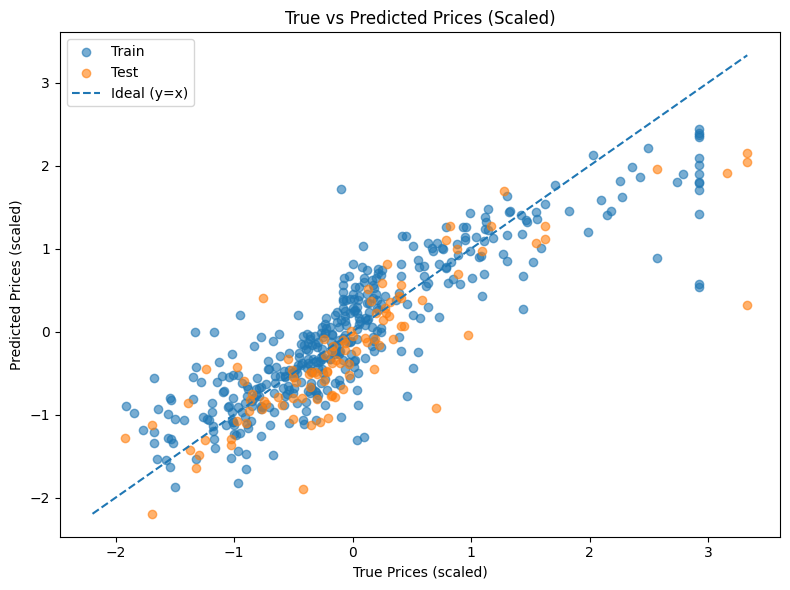

In [14]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))

plt.scatter(y_train_scaled, y_pred_train, alpha=0.6, label="Train")
plt.scatter(y_test_scaled, y_pred_test, alpha=0.6, label="Test")

# Ideal line (y = x)
y_min = min(y_train_scaled.min(), y_test_scaled.min(), y_pred_train.min(), y_pred_test.min())
y_max = max(y_train_scaled.max(), y_test_scaled.max(), y_pred_train.max(), y_pred_test.max())
plt.plot([y_min, y_max], [y_min, y_max], linestyle="--", label="Ideal (y=x)")

plt.xlabel("True Prices (scaled)")
plt.ylabel("Predicted Prices (scaled)")
plt.title("True vs Predicted Prices (Scaled)")
plt.legend()
plt.tight_layout()
plt.show()


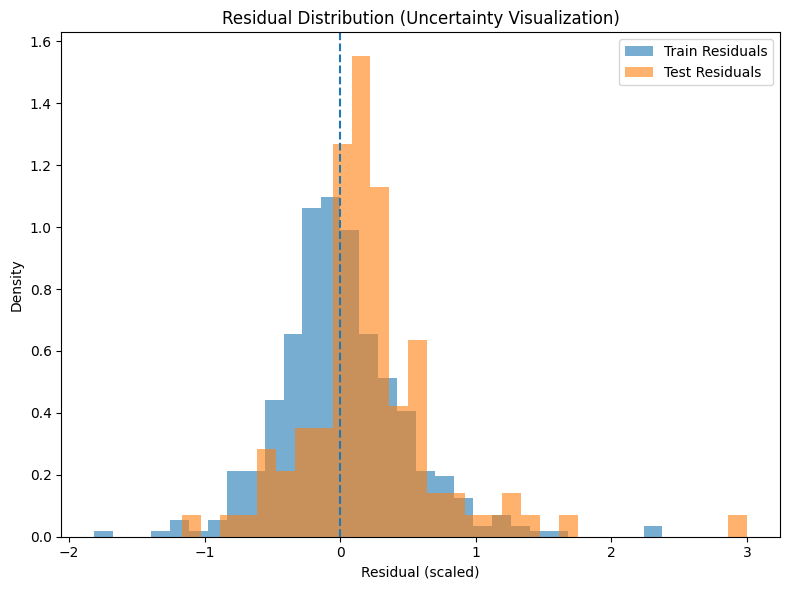

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(residuals_train, bins=30, alpha=0.6, density=True, label="Train Residuals")
plt.hist(residuals_test, bins=30, alpha=0.6, density=True, label="Test Residuals")

plt.axvline(0, linestyle="--")

plt.xlabel("Residual (scaled)")
plt.ylabel("Density")
plt.title("Residual Distribution (Uncertainty Visualization)")
plt.legend()
plt.tight_layout()
plt.show()
